In [9]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Cargar los datos de entrenamiento
datos = pd.read_csv('pollution.csv', index_col='date', parse_dates=True)
datos = datos.drop('wnd_dir', axis=1)
# Limpieza de datos
imputer = SimpleImputer(strategy='mean')
datos = pd.DataFrame(imputer.fit_transform(datos), columns=datos.columns, index=datos.index)
datos.dropna()


,pollution,dew,temp,press,wnd_spd,snow,rain
date,,,,,,,
2010-01-02 00:00:00,129.0,-16.0,-4.0,1020.0,1.79,0.0,0.0
2010-01-02 01:00:00,148.0,-15.0,-4.0,1020.0,2.68,0.0,0.0
2010-01-02 02:00:00,159.0,-11.0,-5.0,1021.0,3.57,0.0,0.0
2010-01-02 03:00:00,181.0,-7.0,-5.0,1022.0,5.36,1.0,0.0
2010-01-02 04:00:00,138.0,-7.0,-5.0,1022.0,6.25,2.0,0.0
...,...,...,...,...,...,...,...
2014-12-31 19:00:00,8.0,-23.0,-2.0,1034.0,231.97,0.0,0.0
2014-12-31 20:00:00,10.0,-22.0,-3.0,1034.0,237.78,0.0,0.0
2014-12-31 21:00:00,10.0,-22.0,-3.0,1034.0,242.70,0.0,0.0


In [37]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43800 entries, 2010-01-02 00:00:00 to 2014-12-31 23:00:00
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pollution  43800 non-null  float64
 1   dew        43800 non-null  float64
 2   temp       43800 non-null  float64
 3   press      43800 non-null  float64
 4   wnd_spd    43800 non-null  float64
 5   snow       43800 non-null  float64
 6   rain       43800 non-null  float64
dtypes: float64(7)
memory usage: 2.7 MB


In [11]:
# Escalado de datos  
scaler = MinMaxScaler(feature_range=(0, 1))    ###transforma los datos en ceros y uno
datos_scales= scaler.fit_transform(datos)

# Crear secuencias de temporales, datos para el entrenamiento
def create_dataset(dataset, look_back=60):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), :]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

X_train, y_train = create_dataset(datos_scales, 60)

In [47]:
# Modelo LSTM
model = Sequential([
    LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),  #return_sequences=True Devuelve salidas para cada paso (necesario para apilar LSTM)
    Dropout(0.2), #evita el sobreajuste , apaga aleatoriamete el 20% de las neuronas durante el entrenamiento#
    LSTM(100, return_sequences=False), #return sequences = False nos da la salid final y no toda la secuencia
  
    Dense(1) #capa final densa
])
model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')

In [48]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 60, 100)           43200     
                                                                 
 dropout_7 (Dropout)         (None, 60, 100)           0         
                                                                 
 lstm_13 (LSTM)              (None, 100)               80400     
                                                                 
 dense_5 (Dense)             (None, 1)                 101       
                                                                 
Total params: 123,701
Trainable params: 123,701
Non-trainable params: 0
_________________________________________________________________


In [49]:
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

Epoch 1/50
1367/1367 [==============================] - 17s 11ms/step - loss: 0.0020
Epoch 2/50
1367/1367 [==============================] - 15s 11ms/step - loss: 9.0799e-04
Epoch 3/50
1367/1367 [==============================] - 15s 11ms/step - loss: 8.6816e-04
Epoch 4/50
1367/1367 [==============================] - 15s 11ms/step - loss: 8.6759e-04
Epoch 5/50
1367/1367 [==============================] - 14s 11ms/step - loss: 8.1658e-04
Epoch 6/50
1367/1367 [==============================] - 15s 11ms/step - loss: 7.9323e-04
Epoch 7/50
1367/1367 [==============================] - 13s 10ms/step - loss: 7.8470e-04
Epoch 8/50
1367/1367 [==============================] - 14s 10ms/step - loss: 7.6993e-04
Epoch 9/50
1367/1367 [==============================] - 15s 11ms/step - loss: 7.5709e-04
Epoch 10/50
1367/1367 [==============================] - 14s 10ms/step - loss: 7.5218e-04
Epoch 11/50
1367/1367 [==============================] - 14s 10ms/step - loss: 7.4303e-04
Epoch 12/50
1367/1367 [

In [50]:
# Preparar los datos reales de para comparación
# Cargar los datos de entrenamiento
datos_real = pd.read_csv('pollution.csv', index_col='date', parse_dates=True)
datos_real = datos_real.drop('wnd_dir', axis=1)
datos_real = pd.DataFrame(imputer.fit_transform(datos_real), columns=datos_real.columns, index=datos_real.index)
real_scaled = scaler.transform(datos_real)


In [51]:
# Crear datos de entrada para predicción
X_real, _ = create_dataset(np.vstack([datos_scales[-60:], real_scaled]), 60)

# Predicciones
predictions_scaled = model.predict(X_real)
predictions = scaler.inverse_transform(np.concatenate([predictions_scaled, np.zeros((len(predictions_scaled), 6))], axis=1))[:, 0]

# Datos reales para comparar
real_popu = scaler.inverse_transform(real_scaled)[:, 0]
real_popu

1369/1369 [==============================] - 6s 4ms/step


array([129., 148., 159., ...,  10.,   8.,  12.])

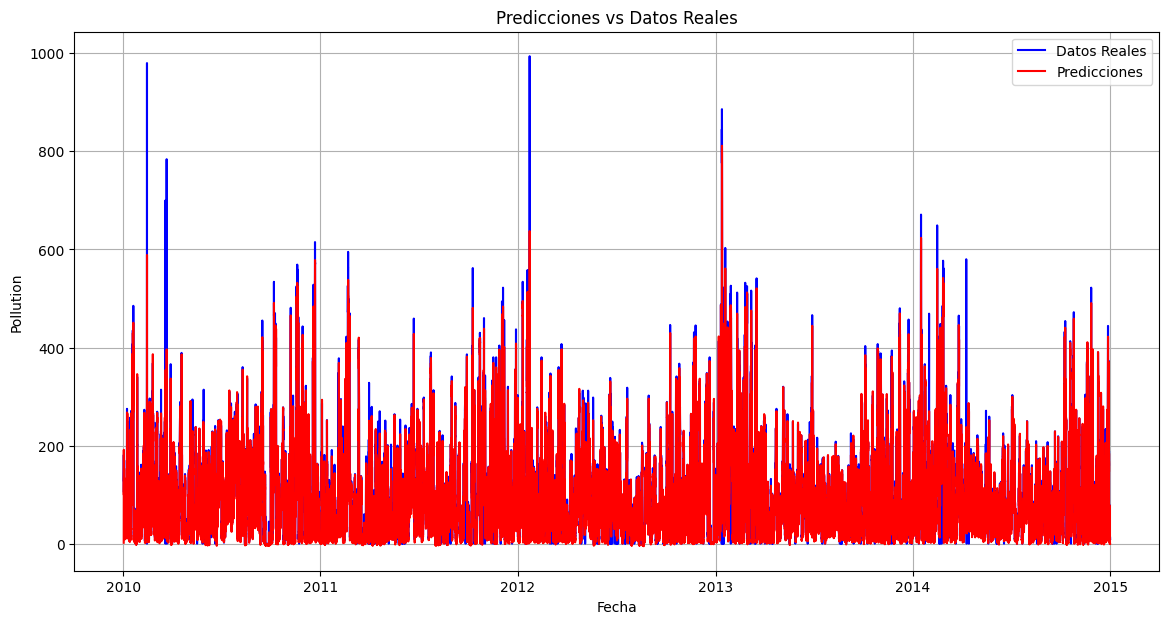

In [52]:
# Graficar
plt.figure(figsize=(14, 7))
plt.plot(datos_real.index, real_popu, label='Datos Reales', color='blue')
plt.plot(datos_real.index[:len(predictions)], predictions, label='Predicciones', color='red')
plt.title('Predicciones vs Datos Reales')
plt.xlabel('Fecha')
plt.ylabel('Pollution')
plt.legend()
plt.grid(True)
plt.show()


# Justificacion:

Se uso una RNN, es este caso la elegida fue LSTM o Long Short-Term Memory, para poder realizar un correcto analizis de los datos, por su forma secuencial y temporal, esto corresponde a la serie cronologica de niveles de contaminacion del aire, tambien se uso LSTM pra evitar el desvanecimiento durante el entrenamiento, aprovechando las puertas de entrada, olvido y salida, con esto el modelo aprende de mejor manera dependencias a largo plazo. El optimizador utilizadfo fue ADAM o Adaptative Moment Estimation, para poder obtener una mejor eficiencia, y tambien aprovechando que este optimizador es mas estable y converge mas rapido en comparacion de otros.